In [120]:
%run -i ./../common/common
%run -i ./zhukovsky
%matplotlib inline

In [99]:
#def zhukovsky_real(p: complex, c: complex) -> float:
#    return zhukovsky(p, c).real

#def zhukovsky_imag(p: complex, c: complex) -> float:
#    return zhukovsky(p, c).imag

#def zhuk_revc(c: complex):
#    def inner(p: complex) -> complex:
#        return zhukovsky(p, c)
#    return inner

In [121]:
def make_circle(center: Coords, r: float, steps: int = 101) -> Grid:
    x0, y0 = center
    angles = np.linspace(-math.pi, math.pi, steps)
    xs = r * np.cos(angles) + x0
    ys = r * np.sin(angles) + y0
    return (xs, ys)

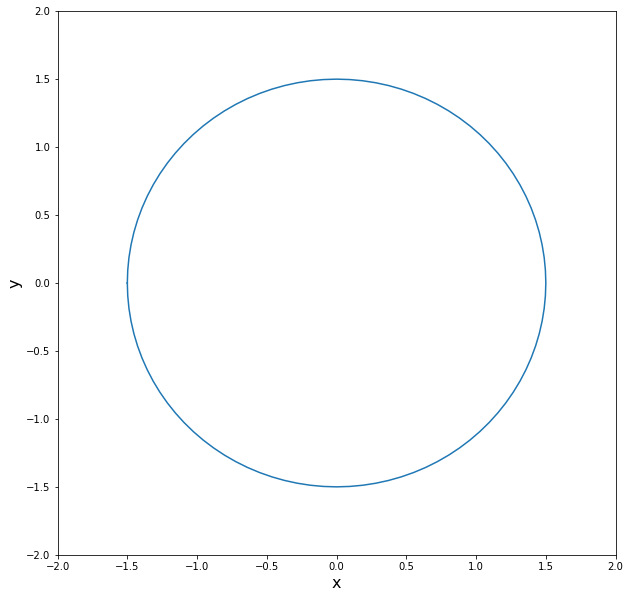

In [122]:
circle = make_circle(Coords(0, 0), 1.5)
size = 10
rect = Rect(-2.0, 2.0, -2.0, 2.0)
setup_fig(rect, size)
plt.plot(*circle)

In [138]:
def zhukovsky_to_shape(grid: Grid, c: complex) -> Grid:
    xs, ys = grid
    complex_points = map(complex, xs, ys)
    zxs = np.fromiter(map(zhukovsky_real(c), complex_points), xs.dtype)
    complex_points = map(complex, xs, ys)
    zys = np.fromiter(map(zhukovsky_imag(c), complex_points), xs.dtype)
    return (zxs, zys)

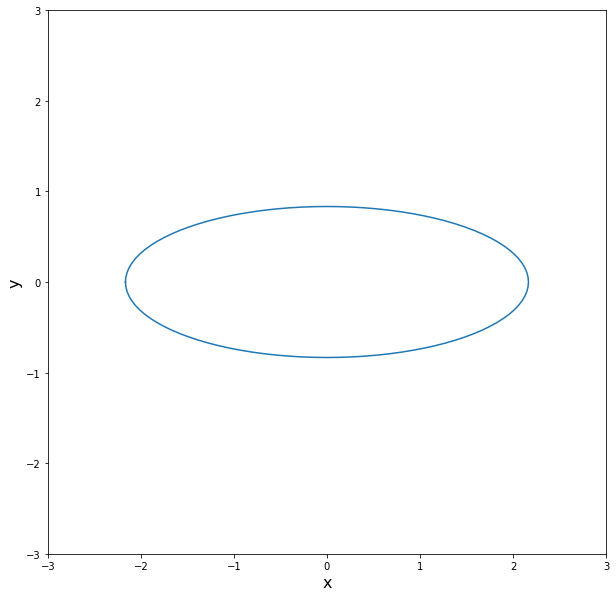

In [124]:
transformed = zhukovsky_to_shape(circle, 1.0 + 0.0j)
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

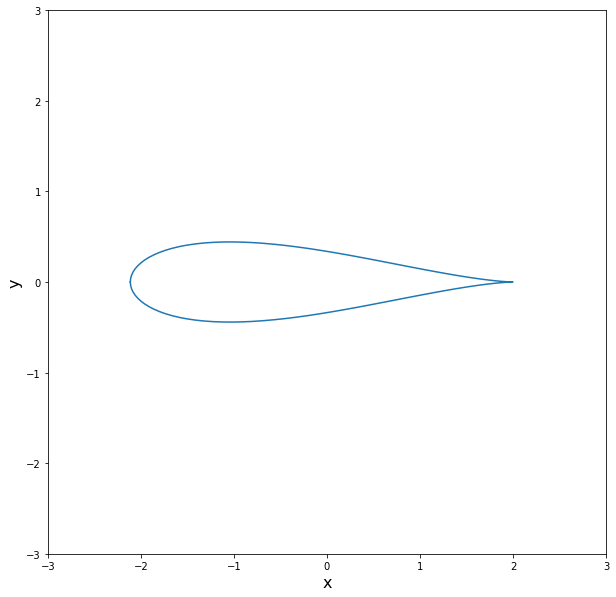

In [125]:
r = 1.2
c = 1.0 + 0.0j
center = Coords(c.real - r, 0.0)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

size = 10
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

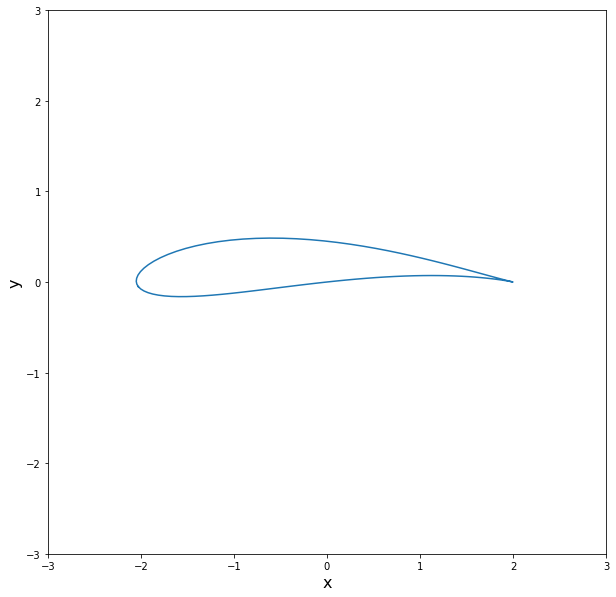

In [126]:
c = 1.0 + 0.0j
center = Coords(0.1, 0.1)
r = math.sqrt((c.real - center.x)**2 + center.y**2)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

setup_fig(rect, size)
plt.plot(*transformed)

In [46]:
def polar_to_rect(R, Phi) -> Grid:
    X = R * np.cos(Phi)
    Y = R * np.sin(Phi)
    return (X, Y)


In [47]:
def make_polar_grid(r_bounds: (float, float), r_steps: int, phi_steps: int) -> Grid:
    r_lo, r_hi = r_bounds
    rs = np.linspace(r_lo, r_hi, r_steps)
    phis = np.linspace(-math.pi, math.pi, phi_steps)
    return np.meshgrid(rs, phis)

In [48]:
def shift_grid(grid: Grid, shift: Coords):
    xs, ys = grid
    xs += shift.x
    ys += shift.y

In [152]:
def zhukovsky_to_grid(grid: Grid, c: complex) -> Grid:
    xs, ys = zhukovsky_to_shape((grid[0].flatten(), grid[1].flatten()), c)
    xs = xs.reshape(np.shape(grid[0]))
    ys = ys.reshape(np.shape(grid[1]))
    return (xs, ys)
    

In [140]:
rect = Rect(-6.0, 6.0, -6.0, 6.0)
size = 5
radgrid = [*polar_to_rect(*make_polar_grid((1.15, 5.0), 100 + 1, 145 + 1))]
center = Coords(-0.15, 0.0)
shift_grid(radgrid, center)

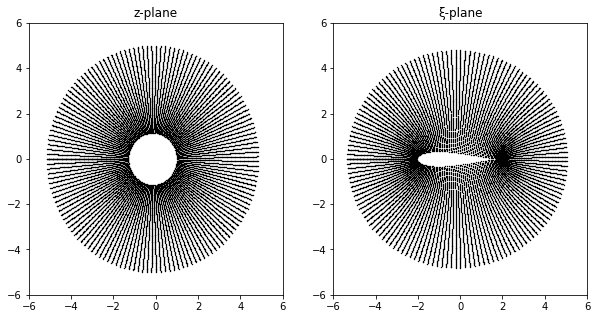

In [155]:
fig = plt.figure(figsize = (size * 2, rect.height / rect.width * size))

zplot = fig.add_subplot(1, 2, 1)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('z-plane')
plt.scatter(*radgrid, s = 2, color = '#000000', marker = 'o', linewidth = 0)

c = 1.0 + 0.0j
profile = [*zhukovsky_to_grid(radgrid, c)]
sigma_plot = fig.add_subplot(1, 2, 2)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('Оѕ-plane')
plt.scatter(*profile, s = 2, color = '#000000', marker = 'o', linewidth = 0)

In [51]:
%run -i ./../source_sink_freestream/freestream
%run -i ./../doublet/doublet

In [52]:
plt.close()

In [72]:
def strength_for_radius(r: float, u_inf: float) -> float:
    return  2 * math.pi * r * r * u_inf

(146, 101)


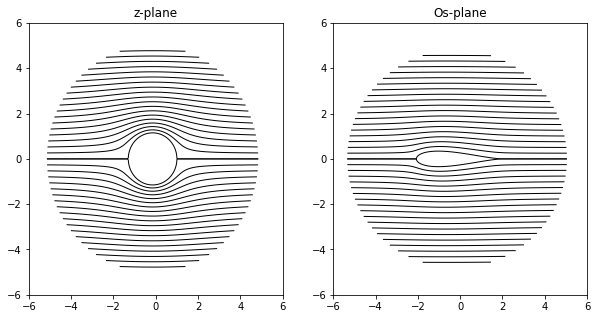

In [187]:
stream = Freestream(1.0)
doublet = Doublet(*center, strength_for_radius(1.15, stream.vel_inf))
levels = [
    np.linspace(-6.0, -0.0000000000001, 25) ,
    np.linspace(+0.0000000000001, 6.0 , 25)
]
levels = np.concatenate(levels)

fig = plt.figure(figsize = (size * 2, rect.height / rect.width * size))

zplot = fig.add_subplot(1, 2, 1)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('z-plane')
pot = stream.potential(radgrid) + doublet.potential(radgrid)
plt.contour(*radgrid, pot,
    levels = levels,
    colors = ['#000000'],
    linestyles = 'solid',
    linewidths = 1.0)

sigma_plot = fig.add_subplot(1, 2, 2)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('РћС•-plane')
pot = stream.potential(radgrid) + doublet.potential(radgrid)
pot = pot.reshape(np.shape(profile[0]))
print(np.shape(pot))
plt.contour(*profile, pot,
    levels = levels,
    colors = ['#000000'],
    linestyles = 'solid',
    linewidths = 1.0)